# Simple SageMaker Sample: XGBoost Hyperparameter Tuning, Training & Deployment

## Contents

1. [Introduction](#Introduction)
2. [Preparation](#Preparation)
3. [Get the Data](#Download-and-prepare-the-data)
4. [Simple Model Training](#Perform-a-simple-training-job)
5. [Hyperparameter Optimization Model Training](#Hyper-parameter-tuning)
6. [Deploy Model](#Deploy-our-model)
7. [Local Deploy and Testing](#Local-deploy-and-testing)

## Introduction
This notebook walks through building a SageMaker model using the SageMaker Python APIs.  We are using Tensorflow as the framework that drives our training jobs.  The samples here have been copied and modified from the various examples and notebooks published by AWS on the AWS GitHub site.

For a deeper dive into next steps on SageMaker model deployment and monitoring, check out this full day self-paced [Immersion Day](https://sagemaker-immersionday.workshop.aws/en/prerequisites.html)

## Preparation

In [ ]:
# Install dependencies.
!pip install zipfile38

In [ ]:
# Python Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
import sys
import math
import os
import time
import zipfile
import sagemaker
from sagemaker.predictor import csv_serializer
import boto3
from sagemaker.tuner import (
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker.inputs import TrainingInput
from sagemaker.tensorflow import TensorFlow
from sagemaker.image_uris import retrieve

# Define Session Variables
region = boto3.Session().region_name
sagemaker_client = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

# Set the S3 we will use for this, replace with the value you will use for this lab.
bucket = "BUCKET-NAME-HERE"
prefix = "bank-additional"

# Request the algorithm image & version from this region
container = retrieve("xgboost", region, "latest")

## Download and Prepare the Data
In this section we will prepare our training, validation, and test data sets for our model.  There are several steps in this section that we will perform by hand using numpy and pandas.  However, all of these steps can be automated in [SageMaker Studio using DataWrangler](https://sagemaker-immersionday.workshop.aws/lab1/option1.html).  

The sections in the data preparation piece of this lab are as follows:
1. Download the data set
2. Perform preliminary analysis
3. Feature Engineering
4. Shuffle, Split & Store to S3

The example data set we are using is designed to predict if customers of a bank will enroll for a CD (certificate of deposit).  The data set has been sourced from the University of California, Irvine, and a version of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

#### Input Variables
##### Bank Client Data:
1. **age** (numeric)
2. **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. **education** (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. **default**: has credit in default? (categorical: 'no','yes','unknown')
6. **housing**: has housing loan? (categorical: 'no','yes','unknown')
7. **loan**: has personal loan? (categorical: 'no','yes','unknown')

##### Related to the Last Contact of the Current Campaign:
8. **contact**: contact communication type (categorical: 'cellular','telephone')
9. **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### Other Features:
12. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. **previous**: number of contacts performed before this campaign and for this client (numeric)
15. **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### Socieconomic Context Features:
16. **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
17. **cons.price.idx**: consumer price index - monthly indicator (numeric)
18. **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)
19. **euribor3m**: euribor 3 month rate - daily indicator (numeric)
20. **nr.employed**: number of employees - quarterly indicator (numeric)

#### Output Cariable (desired target)
1. **y** - has the client subscribed a term deposit? (binary: 'yes','no')

### Download the Data Set

In [ ]:
!wget https://sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
    
with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_rows', 20)
data

### Perform Preliminary Analysis

Here we will plot observations from our dataset.  The goal here is to understand how our dataset looks and what features correlate to each other.

In [ ]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))
    
# Histograms for each numeric feature
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10,10))

In [ ]:
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))
        
for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

In [ ]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12,12))
plt.show()

### Feature Engineering
Here we perform some feature engineering.  First, we define a column that describes if a customer has been contacted once before.  Then, we conflate employment information to describe if a person is working or not.  Then we perform One-Hot Encoding on our categorical features.  Finally, we drop a few columns that we have already discerned are inconsequential to column `y`.

In [ ]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)
model_data = pd.get_dummies(data)
model_data

In [ ]:
model_data = model_data.drop(columns=['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])
model_data

### Shuffle, Split, Store in S3
This is a straightforward process of partitioning our dataset to be used to train, validate, and test our model.

In [ ]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

print("Training Data Length ==> " + str(len(train_data.columns)))
print("Validation Data Length ==> " + str(len(validation_data.columns)))
print("Test Data Length ==> " + str(len(test_data.columns)))

In [ ]:
train_data_csv = pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=True)
pd.read_csv('train.csv')

In [ ]:
test_data

In [ ]:
test_data = test_data.drop(['y_no', 'y_yes'], axis=1)
test_data

In [ ]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Perform a Simple Training Job

In this section we'll discuss the various methods of training models in SageMaker.  We are using XGBoost as the avatar for this discussion.  There are several ways to train models in SageMaker; refer to the following outline for guidance.

https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#xgboost-modes

In [ ]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "binary:logistic",
    "num_round": "100",
    "verbosity": "2",
    "silent": "0",
}

job_name = "BlueOceanID-xgboost-spot-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Training job", job_name)

use_spot_instances = True
max_run = 3600
max_wait = 3600 if use_spot_instances else None
checkpoint_s3_uri = (
    "s3://{}/{}/checkpoints/{}".format(bucket, prefix, job_name) if use_spot_instances else None
)
print("Checkpoint path:", checkpoint_s3_uri)

xgb_model = sagemaker.estimator.Estimator(
    container,
    role,
    hyperparameters=hyperparameters,
    instance_count=1,
#     instance_count=4,
    instance_type="ml.m5.2xlarge",
    volume_size=5,  # GB
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker.Session(),
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
    checkpoint_s3_uri=checkpoint_s3_uri,
)
train_input = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "train/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "validation/validation.csv"), content_type="csv"
)
xgb_model.fit({"train": train_input, "validation": validation_input}, job_name=job_name)
xgb_model.model_data

## Deploy Our Model
In this section we will discuss two seperate deployment paradigms.  We will deploy our model using a SageMaker hosted endpoint first, followed by a local deployment.  The steps for local deployment can be reused to deploy to a machine in a private or self-hosted environment.

In [ ]:
# Here we deploy the simple XGBoost model we trained earlier...
from sagemaker.serializers import CSVSerializer
predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=CSVSerializer()
)

### Test our Deployed Model

In this section we'll utilize the testing data we created earlier on the model we deployed to a SageMaker endpoint.

Now, we’ll use a simple function to: 
1. Loop over our test dataset 
2. Split it into mini-batches of rows 
3. Convert those mini-batchs to CSV string payloads 
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint 
5. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [ ]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, predictor.predict(array).decode("utf-8")])

    return np.fromstring(predictions[1:], sep=",")

In [ ]:
predictions = predict(test_data.to_numpy()[:, 1:])
print(predictions)

In [ ]:
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

In [ ]:
plt.hist(predictions)
plt.show()

In [ ]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

In [ ]:
predictor.delete_endpoint()

## Hyper Parameter Tuning

Hyperparameter Tuning is a feature of Amazon SageMaker that allows customers to find the best hyperparameter values for their training jobs in the least amount of time.  This feature is available in the SageMaker UI within the AWS Console, the AWS CLI, and via the Python SageMaker API.  We will describe how to submit a HTJ (Hyperparameter Tuning Job) via API calls in this document.

The steps to submit an HTJ via the SageMaker Python API are as follows:
1. Decide which algorithm you want to tune.
2. Set initial weights on the hyperparameters for the selected algorithm.
3. Define the range of hyperparameters you want to tune against.
4. Define your hyperparameter tuning job.
5. Train your hyperparameter tuning job.
6. Evaluate the your results.

### Decide which algorithm to tune
Amazon SageMaker Hyperparameter Tuning allows you to tune built-in SageMaker algorithms as well as custom algorithms that you bring to the training environment.  To complete this process, you need to pull the model container using the `sagemaker.image_uris.retrieve` function call.  This function takes a model name, region and version number as parameters and returns a container object.

In [ ]:
sagemaker_session = sagemaker.Session()

# Create a reference to an XGBoost model with the retrieved image
# The API call tells SageMaker what the algorithm is, what permissions it has, 
#   what kind and how many instances to train with, where output should do,
#   and the session credentials for this algorithms.
hyper_xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
)

### Set Initial Weights on Hyperparameters

Every algorithms has different hyperparameters.  Before you run a training job for hyperparameter tuning you need to set default weights on the algorithm for these hyperparameters.  During this phase we will also set the objective metric for the HTJ.

The objective metric is a metric used by Amazon SageMaker to compare the performance of hyperparameter tuning jobs against each other.  The model with the best performing metric is the model that should be used for training.

Every algorithm will have different hyperparameters.  It is important to understand what these hyperparameters are and they work at a high level before running an HTJ.  [XGBoost Hyperparameters & Objective Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) are listed in the AWS Documentation for Amazon SageMaker.  

In [ ]:
# Set the initial weights on XGBoost
hyper_xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=10,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
)

# Set the Objective Metric to compare job runs.
# This validation metric is Area Under the Curve.
objective_metric_name = "validation:auc"

### Define the range of Hyperparameters you want to Tune

Amazon SageMaker Hyperparameter Tuning Jobs require a specific range of values to use when testing hyperparameters.  You need to specify these ranges as `sagemaker.parameter.ParameterRange` objects in a dictionary.  This class is implemented in the `sagemaker.tuner` package with implementations for `IntegerParameter`, `CategoricalParameter` & `ContinuousParameter`.  In this example, we'll tune continuous parameters.

When specifying a parameter to tune, you pass a minimum value, a maximum value, and a scaling type.  Amazon SageMaker Hyperparameter Tuning Jobs support Linear and Logarithmic scaling for parameters.  Test both and see which perform best for you.

In [ ]:
hyperparameter_ranges_logarithmic = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}

hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
}

### Random vs. Bayesian; Linear vs. Logarithmic 

There are four types of hyperparameter tuning jobs you can run, we will showcase them here.

In [ ]:
import string
import random

client = boto3.client("sagemaker")

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "train/train.csv"), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "validation/validation.csv"), content_type="csv"
)

letters = string.ascii_lowercase

### Submit the Hyperparameter Tuning Job

A Hyperparameter Tuning Job is represented in the SageMaker API as a `HyperparameterTuner` object.  To create this object we must pass in many of the objects we've created up until this point.  We supply the algorithm we will tune, the objective metric, and the hyperparameter ranges.  Furthermore, we will set the number of jobs to run and the parallelization of these jobs.  

Finally, we must specify our tuning strategy.  Hyperparameter Tuning Jobs take a `Random` or `Bayesian` strategy, and we will showcase both in this example.

The `fit(dict, bool)` method submits your Hyperparameter Tuning Job to Amazon SageMaker.  The hardware specified in the algorithm definition is initialized and the jobs are run in accordance with the instructions defined within the `HyperparameterTuner` job.

The hyperparameter ranges we've specified will be tested and modified across all of the jobs that run; these values will change based on the scaling strategy you utilize.

#### Random Linear Scaling Hyperparameter Tuning Job

In [ ]:
# Random Search Hyperparameter Tuning Job that scales Linearly.
random_linear_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Random",
)

suffix = ''.join(random.choice(letters) for i in range(10))
random_linear_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="random-linear-tuner-" + suffix
)

In [ ]:
random_linear_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=random_linear_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [ ]:
random_linear_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    random_linear_tuner_log.latest_tuning_job.job_name
).dataframe()
random_linear_df_log["strategy"] = "random|linear"

#### Random Logarithmic Scaling Hyperparameter Tuning Job

In [ ]:
# Random Search Hyperparameter Tuning Job that scales Logarithmically.
random_logarithmic_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_logarithmic,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Random",
)

suffix = ''.join(random.choice(letters) for i in range(7))
random_logarithmic_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="random-logarithmic-tuner-" + suffix
)

In [ ]:
random_logarithmic_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=random_logarithmic_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [ ]:
random_logarithmic_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    random_logarithmic_tuner_log.latest_tuning_job.job_name
).dataframe()
random_logarithmic_df_log["strategy"] = "random|logarithmic"

#### Bayesian Linear Scaling Hyperparameter Tuning Job

In [ ]:
# Bayesian Search Hyperparameter Tuning Job that scales Linearly.
bayesian_linear_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Bayesian",
)

suffix = ''.join(random.choice(letters) for i in range(10))
bayesian_linear_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="bayesian-linear-tuner-" + suffix
)

In [ ]:
bayesian_linear_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=bayesian_linear_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [ ]:
bayesian_linear_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    bayesian_linear_tuner_log.latest_tuning_job.job_name
).dataframe()
bayesian_linear_df_log["strategy"] = "bayesian|linear"

#### Bayesian Logarithmic Scaling Hyperparameter Tuning Job

In [111]:
# Bayesian Search Hyperparameter Tuning Job that scales Logarithmically.
bayesian_logarithmic_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_logarithmic,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Bayesian",
)

suffix = ''.join(random.choice(letters) for i in range(5))
bayesian_logarithmic_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="bayesian-logarithmic-tuner-" + suffix
)

.........................................................................................!


In [112]:
bayesian_logarithmic_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=bayesian_logarithmic_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [113]:
bayesian_logarithmic_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    bayesian_logarithmic_tuner_log.latest_tuning_job.job_name
).dataframe()
bayesian_logarithmic_df_log["strategy"] = "bayesian|logarithmic"


### Evaluate the results

Using third party libraries we plot the performance of the hyperparameter tuning jobs in a visualization.

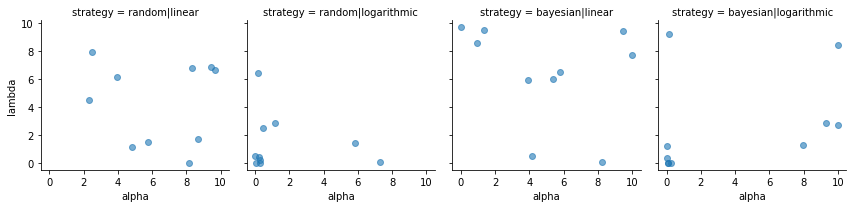

In [114]:
########################################################################
# Create the Pandas dataframe that plots the performance of our models #
########################################################################

# HOW DO LAMBDA AND ALPHA PLAY TOGETHER WITH XGBOOST?

# REMINDER: As Alpha and Lambda increase, the model becomes more conservative.
# Since we are using AUC as the objective metric, we can assume smaller values will be preferred.

df = pd.concat([
    random_linear_df_log,
    random_logarithmic_df_log,
    bayesian_linear_df_log,
    bayesian_logarithmic_df_log
], ignore_index=True)

g = sns.FacetGrid(df, col="strategy", palette="viridis")
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)

This concludes our segment on Hyperparameter Tuning.  The next task is to select the model we want to work with and deploy that model.

### Deploy Our Hyperparameter Trained Model
In this section we will discuss two seperate deployment paradigms.  We will deploy our model using a SageMaker hosted endpoint first, followed by a local deployment.  The steps for local deployment can be reused to deploy to a machine in a private or self-hosted environment.

In [ ]:
# Here we deploy the best of 1 of the 4 models...
from sagemaker.serializers import CSVSerializer
hyper_predictor = random_linear_tuner_log.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=CSVSerializer()
)

### Test our Deployed Hyperparameter Model

In this section we'll utilize the testing data we created earlier on the model we deployed to a SageMaker endpoint.

Now, we’ll use a simple function to: 
1. Loop over our test dataset 
2. Split it into mini-batches of rows 
3. Convert those mini-batchs to CSV string payloads 
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint 
5. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [ ]:
def hyperparameter_model_predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, hyper_predictor.predict(array).decode("utf-8")])

    return np.fromstring(predictions[1:], sep=",")

In [ ]:
predictions = hyperparameter_model_predict(test_data.to_numpy()[:, 1:])
print(predictions)

In [ ]:
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

In [ ]:
plt.hist(predictions)
plt.show()

In [ ]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

In [115]:
hyper_predictor.delete_endpoint()